In [2]:
#Basic notebook with a few jupyter examples - use case is calc out of date warranties
# Load and process a CSV

#Handle users that have never logged on to an app to which they are assigned  ... but that are not new to the app. 
# Generate recommendations for each user X app. 



#Metrics





# Metrics to calc
#    number of product purchases that are either out of warranty or obsolete
# Users that haven't purchased in a while
# Last purchase per user - any product

#Last login per user - each app
#  * somehow include no logins - for ones that they have been assigned

#TODO handle case where user has never logged in to an ap to which they have been assigned. 
#TODO handle case where a user is brand new to an app.



In [44]:
import numpy as np
import pandas as pd
import logging
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from check_df import check_df, fix_empty_cells

logging.basicConfig(level=logging.DEBUG, format="%(message)s")
LOGGER = logging.getLogger('arappaport')
LOGGER.debug("log level = %s", str(LOGGER.getEffectiveLevel()))


log level = 10


In [4]:
# Params - Moved these to command line or env in final version 
DATA_PATH="./data/user_app_access.csv"
DATE_AS_OF=date.fromisoformat('2023-06-01') #Date for analysis
#For data visualization - date range sizes
DATE_GROUP_DAYS=30
CUTOFF_DAYS=90

REQUIRED_COLUMNS=['user','date','app']
REQUIRED_VALUES=['user', 'date','app']

#list of recommended actions for different date thresholds. 
DEFAULT_ACTION='ok'
ACTION_DATES = dict(suspend=60, remove=120)
#sort so the largest date value is first in dict.  i.e., we want to recommend the action with the largest date range
actions = {k: v for k, v in sorted(ACTION_DATES.items(), key=lambda item: item[1], reverse=True)} 



In [5]:
df_all = pd.read_csv(DATA_PATH)
df_all.head()

,user,date,app
0,A,2023-05-31,app-a
1,B,2023-06-01,app-a
2,C,2023-05-01,app-b
3,D,2023-06-01,app-a
4,D,2023-05-15,app-a


In [6]:
# replace empty cells with None to clean up data.
fix_empty_cells(df_all, inplace=True)
df_all.head()

,user,date,app
0,A,2023-05-31,app-a
1,B,2023-06-01,app-a
2,C,2023-05-01,app-b
3,D,2023-06-01,app-a
4,D,2023-05-15,app-a


In [7]:
#check dataframe for missing blocks.  err is empty if no errors - otherwise an err str
err = check_df(df_all, required_columns=REQUIRED_COLUMNS, required_values=REQUIRED_VALUES)
if err:
    print(str(err))
    Exception(err)
    
LOGGER.info("Loaded %d clean rows from CSV[%s]", len(df_all), DATA_PATH)

#fixup convert 8601 strings to dates
df_all['date']      = pd.to_datetime(df_all['date'], format='%Y-%m-%d').dt.date

#Add number of days since date.   Makes some downstream calcs a little easier
df_all['days_ago'] = df_all['date'].apply(lambda x: (DATE_AS_OF - x).days)
df_all.head()


Num empty required cells in dataframe: 0
Loaded 22 clean rows from CSV[./data/user_app_access.csv]


,user,date,app,days_ago
0,A,2023-05-31,app-a,1
1,B,2023-06-01,app-a,0
2,C,2023-05-01,app-b,31
3,D,2023-06-01,app-a,0
4,D,2023-05-15,app-a,17


In [8]:
#########Recommend actions based on date of last login
def determine_action(days:int) ->str: 
    for action, d_thresehold in actions.items():
        if days >= d_thresehold:
            return action
    return DEFAULT_ACTION

df_all['action'] = df_all['days_ago'].apply(determine_action)
df_all.head(5)

#Find the ones beyond the dates. 

,user,date,app,days_ago,action
0,A,2023-05-31,app-a,1,ok
1,B,2023-06-01,app-a,0,ok
2,C,2023-05-01,app-b,31,ok
3,D,2023-06-01,app-a,0,ok
4,D,2023-05-15,app-a,17,ok


In [9]:
#####################################
#most recent purchases per user - any product
df_recent = df_all.sort_values(by='date', ascending=False)

# group the data by Name and get the first row of each group
df_most_recent_purchases = df_recent.groupby('user').first()
df_most_recent_purchases.head()


,date,app,days_ago,action
user,,,,
A,2023-05-31,app-a,1,ok
B,2023-06-01,app-a,0,ok
C,2023-05-01,app-b,31,ok
D,2023-06-01,app-a,0,ok
E,2023-01-01,app-b,151,remove


In [10]:
#####################################
#most recent login per user - any app

df_recent = df_all.sort_values(by='date', ascending=False)

# group the data by Name and get the most recent login (first row) of each group
df_most_recent_login = df_recent.groupby(['user'],as_index=False).first()
df_most_recent_login.head(5)

,user,date,app,days_ago,action
0,A,2023-05-31,app-a,1,ok
1,B,2023-06-01,app-a,0,ok
2,C,2023-05-01,app-b,31,ok
3,D,2023-06-01,app-a,0,ok
4,E,2023-01-01,app-b,151,remove


In [11]:
#####################################
#most recent login per user - list all products

df_recent = df_all.sort_values(by='date', ascending=False)

# group the data by Name and get the most recent login (first row) of each group
df_most_recent_login_all = df_recent.groupby(['user', 'app'],as_index=False).first()
df_most_recent_login_all.head(15)

,user,app,date,days_ago,action
0,A,app-a,2023-05-31,1,ok
1,A,app-a,2023-02-28,93,suspend
2,A,app-b,2023-03-21,72,suspend
3,A,app-c,2023-03-12,81,suspend
4,A,app-d,2023-03-18,75,suspend
5,B,app-a,2023-06-01,0,ok
6,B,app-b,2023-02-07,114,suspend
7,B,app-d,2023-03-03,90,suspend
8,C,app-a,2023-03-06,87,suspend
9,C,app-b,2023-05-01,31,ok


In [12]:
### Find login that are old - such as out of warranty date.
#filtered_df = df_most_recent_login_all.loc[df_most_recent_login_all['date'] < '2023-02-01']

#print(f"Num login out of warranty: {len(filtered_df)}")
#filtered_df.head(5)


In [13]:
#####################################
# Last login per user per app
#
# Note: this doesn't handle case where a user never logged-in
#####################################
#Generate blocks of cutoff days.    The first is the max.
dates = []
dateblocks = {}

dmin = df_all['date'].min()
print(f"dmin: Earliest entry from date: {dmin}")
d = DATE_AS_OF
ndays = 0
while d >= dmin:
 dates.insert(0,d)

 prevdate = d - timedelta(days=DATE_GROUP_DAYS)
 ndays_max=ndays + DATE_GROUP_DAYS-1
 dateblocks[ndays] = dict(ndays=ndays,
                          date=d,
                          prevdate=prevdate,
                          ndays_max = ndays_max,
                          label=f"{ndays} to {ndays_max} days")

 #Next block
 d = prevdate
 ndays += DATE_GROUP_DAYS

 print(f"date slice: {d}")

dmin: Earliest entry from date: 2023-01-01
date slice: 2023-05-02
date slice: 2023-04-02
date slice: 2023-03-03
date slice: 2023-02-01
date slice: 2023-01-02
date slice: 2022-12-03


In [34]:
dateblocks

{0: {'ndays': 0,
  'date': datetime.date(2023, 6, 1),
  'prevdate': datetime.date(2023, 5, 2),
  'ndays_max': 29,
  'label': '0 to 29 days'},
 30: {'ndays': 30,
  'date': datetime.date(2023, 5, 2),
  'prevdate': datetime.date(2023, 4, 2),
  'ndays_max': 59,
  'label': '30 to 59 days'},
 60: {'ndays': 60,
  'date': datetime.date(2023, 4, 2),
  'prevdate': datetime.date(2023, 3, 3),
  'ndays_max': 89,
  'label': '60 to 89 days'},
 90: {'ndays': 90,
  'date': datetime.date(2023, 3, 3),
  'prevdate': datetime.date(2023, 2, 1),
  'ndays_max': 119,
  'label': '90 to 119 days'},
 120: {'ndays': 120,
  'date': datetime.date(2023, 2, 1),
  'prevdate': datetime.date(2023, 1, 2),
  'ndays_max': 149,
  'label': '120 to 149 days'},
 150: {'ndays': 150,
  'date': datetime.date(2023, 1, 2),
  'prevdate': datetime.date(2022, 12, 3),
  'ndays_max': 179,
  'label': '150 to 179 days'}}

In [35]:
#df_all['days_since_login'] = df_all['date'].apply(lambda d: (DATE_AS_OF - d.date()).days)

def calc_date_block(ndays):
    """
    Return the appropriate date block range for the given number of days. 
    note: this is used as an apply lambda.   it users the global dateblocks dict.  It is assumed that date blocks is sorted largest to smallest
    :param ndays:   
    :return: 
    """

    for d in sorted(dateblocks.keys()):
        v = dateblocks[d]
        print(f"calc_date_block d={str(d)}  v={dateblocks.get(d)}")

        if ndays <= v.get('ndays_max'):
            return v.get('ndays')
    return -1

df_all['days_since_group'] = df_all['days_ago'].apply(calc_date_block)
df_all['days_since_label'] = df_all['days_since_group'].apply(lambda x: dateblocks.get(x).get('label'))

df_all.head(5)

calc_date_block d=0  v={'ndays': 0, 'date': datetime.date(2023, 6, 1), 'prevdate': datetime.date(2023, 5, 2), 'ndays_max': 29, 'label': '0 to 29 days'}
calc_date_block d=0  v={'ndays': 0, 'date': datetime.date(2023, 6, 1), 'prevdate': datetime.date(2023, 5, 2), 'ndays_max': 29, 'label': '0 to 29 days'}
calc_date_block d=0  v={'ndays': 0, 'date': datetime.date(2023, 6, 1), 'prevdate': datetime.date(2023, 5, 2), 'ndays_max': 29, 'label': '0 to 29 days'}
calc_date_block d=30  v={'ndays': 30, 'date': datetime.date(2023, 5, 2), 'prevdate': datetime.date(2023, 4, 2), 'ndays_max': 59, 'label': '30 to 59 days'}
calc_date_block d=0  v={'ndays': 0, 'date': datetime.date(2023, 6, 1), 'prevdate': datetime.date(2023, 5, 2), 'ndays_max': 29, 'label': '0 to 29 days'}
calc_date_block d=0  v={'ndays': 0, 'date': datetime.date(2023, 6, 1), 'prevdate': datetime.date(2023, 5, 2), 'ndays_max': 29, 'label': '0 to 29 days'}
calc_date_block d=0  v={'ndays': 0, 'date': datetime.date(2023, 6, 1), 'prevdate': da

,user,date,app,days_ago,action,days_since_group,days_since_label
0,A,2023-05-31,app-a,1,ok,0,0 to 29 days
1,B,2023-06-01,app-a,0,ok,0,0 to 29 days
2,C,2023-05-01,app-b,31,ok,30,30 to 59 days
3,D,2023-06-01,app-a,0,ok,0,0 to 29 days
4,D,2023-05-15,app-a,17,ok,0,0 to 29 days


In [36]:
#orig df_date_bands = df_all.groupby('days_since_label',as_index=False).count()
#try grouping by the block.   Then add the labels as the axis.   or vice versa. 
df_date_bands = df_all.groupby('days_since_label',as_index=False).count()
df_date_bands.head(5)

,days_since_label,user,date,app,days_ago,action,days_since_group
0,0 to 29 days,4,4,4,4,4,4
1,150 to 179 days,1,1,1,1,1,1
2,30 to 59 days,1,1,1,1,1,1
3,60 to 89 days,6,6,6,6,6,6
4,90 to 119 days,10,10,10,10,10,10


,days_since_group,user,date,app,days_ago,action,days_since_label
0,0,4,4,4,4,4,0 to 29 days
1,30,1,1,1,1,1,30 to 59 days
2,60,6,6,6,6,6,60 to 89 days
3,90,10,10,10,10,10,90 to 119 days
4,150,1,1,1,1,1,150 to 179 days


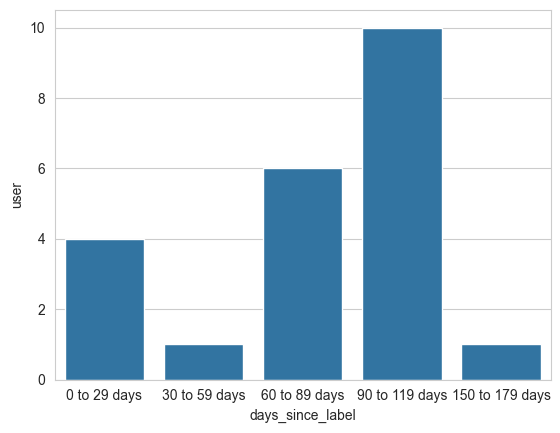

In [37]:
df_date_bands = df_all.groupby('days_since_group',as_index=False).count()
df_date_bands['days_since_label'] = df_date_bands['days_since_group'].apply(lambda x: dateblocks.get(x).get('label'))


sns.barplot(x='days_since_label', y='user',
            #order=df_date_bands['days_since_group'],
            data=df_date_bands) #hue='variable')

df_date_bands.head(5)

In [42]:
################################################################
# Stacked bar of recommendations per app - sorted by app name. 
################################################################

#set up df with just columns we want to use for pivot experiments. 
# Pivot - we want each action as a column for apps with counts as the cells. 
# Basic pivot table with columns of action labels counts
df_action_count = pd.pivot_table(df_all[['app', 'action','days_since_group']], values='days_since_group', index='app', columns='action',
                          aggfunc='count')
df_action_count.fillna(0, inplace=True)
df_action_count = df_action_count.apply(pd.to_numeric, errors='coerce').astype(int)
df_action_count.head(10)


action,ok,remove,suspend
app,,,
app-a,1,0,0
app-a,3,0,5
app-b,1,1,3
app-c,0,0,2
app-d,0,0,6


Text(0.5, 1.0, 'Recommend actions per app')

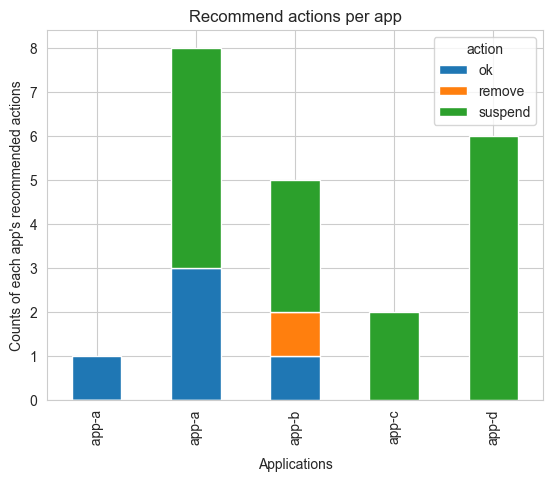

In [46]:
df_action_count.plot(kind='bar', stacked=True)
plt.xlabel('Applications')
plt.ylabel('Counts of each app\'s recommended actions')
 
# title of plot
plt.title("Recommend actions per app")
